In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np
import numpy.random
import xarray as xa

# Generate some data:

In [2]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_observations=2000, num_features=1000)
sim.generate_sample_description(num_batches=0, num_conditions=2)
# sample parameters from positive truncated N(1, 0.1)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

# count data
X = sim.X
# sample description
sample_description = sim.sample_description

Superimpose library size effects on counts:

In [3]:
size_factors = numpy.random.normal(loc=1, scale=0.1, size=X.shape[0]) # draw random factors
size_factors[size_factors < 0.2] = 0.2 # threshold
X = np.round(X*np.repeat(np.expand_dims(size_factors, axis=1), axis=1, repeats=X.shape[1])) # scale counts and round

Check size factor scaling:

In [4]:
np.mean(np.sum(X, axis=1).values/np.mean(np.sum(X, axis=1)).values - size_factors)

-0.0011023774305154066

# Run differential expression test:

## With size factor correction

In [5]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

test = de.test.wald(
    data=X,
    formula="~ 1 + condition",
    factor_loc_totest="condition",
    sample_description=sample_description,
    size_factors=size_factors,
    batch_size=500,
    dtype="float64"
)


Estimating model...
Using closed-form MLE initialization for mean
Should train mu: True
Using closed-form MME initialization for dispersion
Should train r: True


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.1,
  'loss_window_size': 100,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.05,
  'use_batching': True},
 {'convergence_criteria': 't_test',
  'learning_rate': 0.05,
  'loss_window_size': 10,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.05,
  'use_batching': False}]
Beginning with training sequence #1
Training sequence #1 complete
Beginning with training sequence #2
Training sequence #2 complete
Estimating model ready


# Obtaining the results

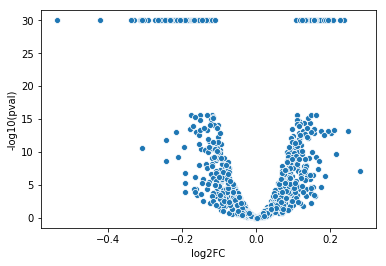

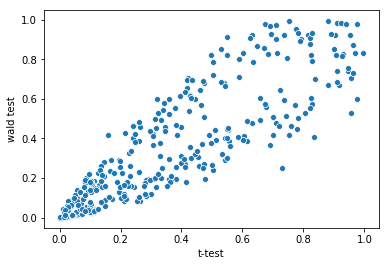

In [6]:
test.plot_diagnostics()

Compare against t-test on size factor normalized data:

## Without size factor correction

In [7]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

test = de.test.wald(
    data=X,
    formula="~ 1 + condition",
    factor_loc_totest="condition",
    sample_description=sample_description,
    size_factors=None,
    batch_size=500,
    dtype="float64"
)


Estimating model...
Using closed-form MLE initialization for mean
Should train mu: False
Using closed-form MME initialization for dispersion
Should train r: True


/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/Users/david.fischer/miniconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


training strategy:
[{'convergence_criteria': 't_test',
  'learning_rate': 0.01,
  'loss_window_size': 10,
  'optim_algo': 'ADAM',
  'stop_at_loss_change': 0.25,
  'use_batching': False}]
Beginning with training sequence #1
Training sequence #1 complete
Estimating model ready


# Obtaining the results

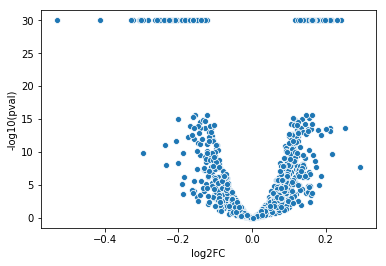

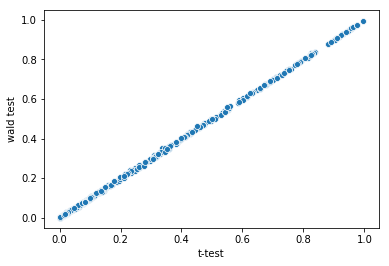

In [8]:
test.plot_diagnostics()